In [119]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [120]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Exploracion con Lasso and Ridge
## Cargar el dataset

In [121]:
dataset_path: Path = Path.cwd() / 'wallmart' / 'Walmart_Sales.csv'
assert dataset_path.exists(), 'Dataset not found'
dataset = pd.read_csv(dataset_path)

## Analisis de dataset

In [122]:
print(dataset.info())
dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB
None


Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0         1  05-02-2010    1643690.90             0        42.31       2.572   
1         1  12-02-2010    1641957.44             1        38.51       2.548   
2         1  19-02-2010    1611968.17             0        39.93       2.514   
3         1  26-02-2010    1409727.59             0        46.63       2.561   
4         1  05-03-2010    1554806.68             0        46.50       2.625   
...     ...         ...           ...           ...          ...         ...   
6430     45  28-09-2012     713173.95             0        64.88       3.997   
6431     45  05-10-2012     733455.07             0        64.89       3.985   
6432     45  12-10-2012     734464.36             0        54.47       4.000   
6433     45  19-10-2012     718125.53             0        56.47       3.969   
6434     45  26-10-2012     760281.43             0        58.85       3.882   

             CPI  Unemployment  
0     211.096358         8.106  
1     211.242170         8.106  
2     211.289143         8.106  
3     211.319643         8.106  
4     211.350143         8.106  
...          ...           ...  
6430  192.013558         8.684  
6431  192.170412         8.667  
6432  192.327265         8.667  
6433  192.330854         8.667  
6434  192.308899         8.667  

[6435 rows x 8 columns]

In [123]:
dataset.describe()

Store  Weekly_Sales  Holiday_Flag  Temperature   Fuel_Price  \
count  6435.000000  6.435000e+03   6435.000000  6435.000000  6435.000000   
mean     23.000000  1.046965e+06      0.069930    60.663782     3.358607   
std      12.988182  5.643666e+05      0.255049    18.444933     0.459020   
min       1.000000  2.099862e+05      0.000000    -2.060000     2.472000   
25%      12.000000  5.533501e+05      0.000000    47.460000     2.933000   
50%      23.000000  9.607460e+05      0.000000    62.670000     3.445000   
75%      34.000000  1.420159e+06      0.000000    74.940000     3.735000   
max      45.000000  3.818686e+06      1.000000   100.140000     4.468000   

               CPI  Unemployment  
count  6435.000000   6435.000000  
mean    171.578394      7.999151  
std      39.356712      1.875885  
min     126.064000      3.879000  
25%     131.735000      6.891000  
50%     182.616521      7.874000  
75%     212.743293      8.622000  
max     227.232807     14.313000

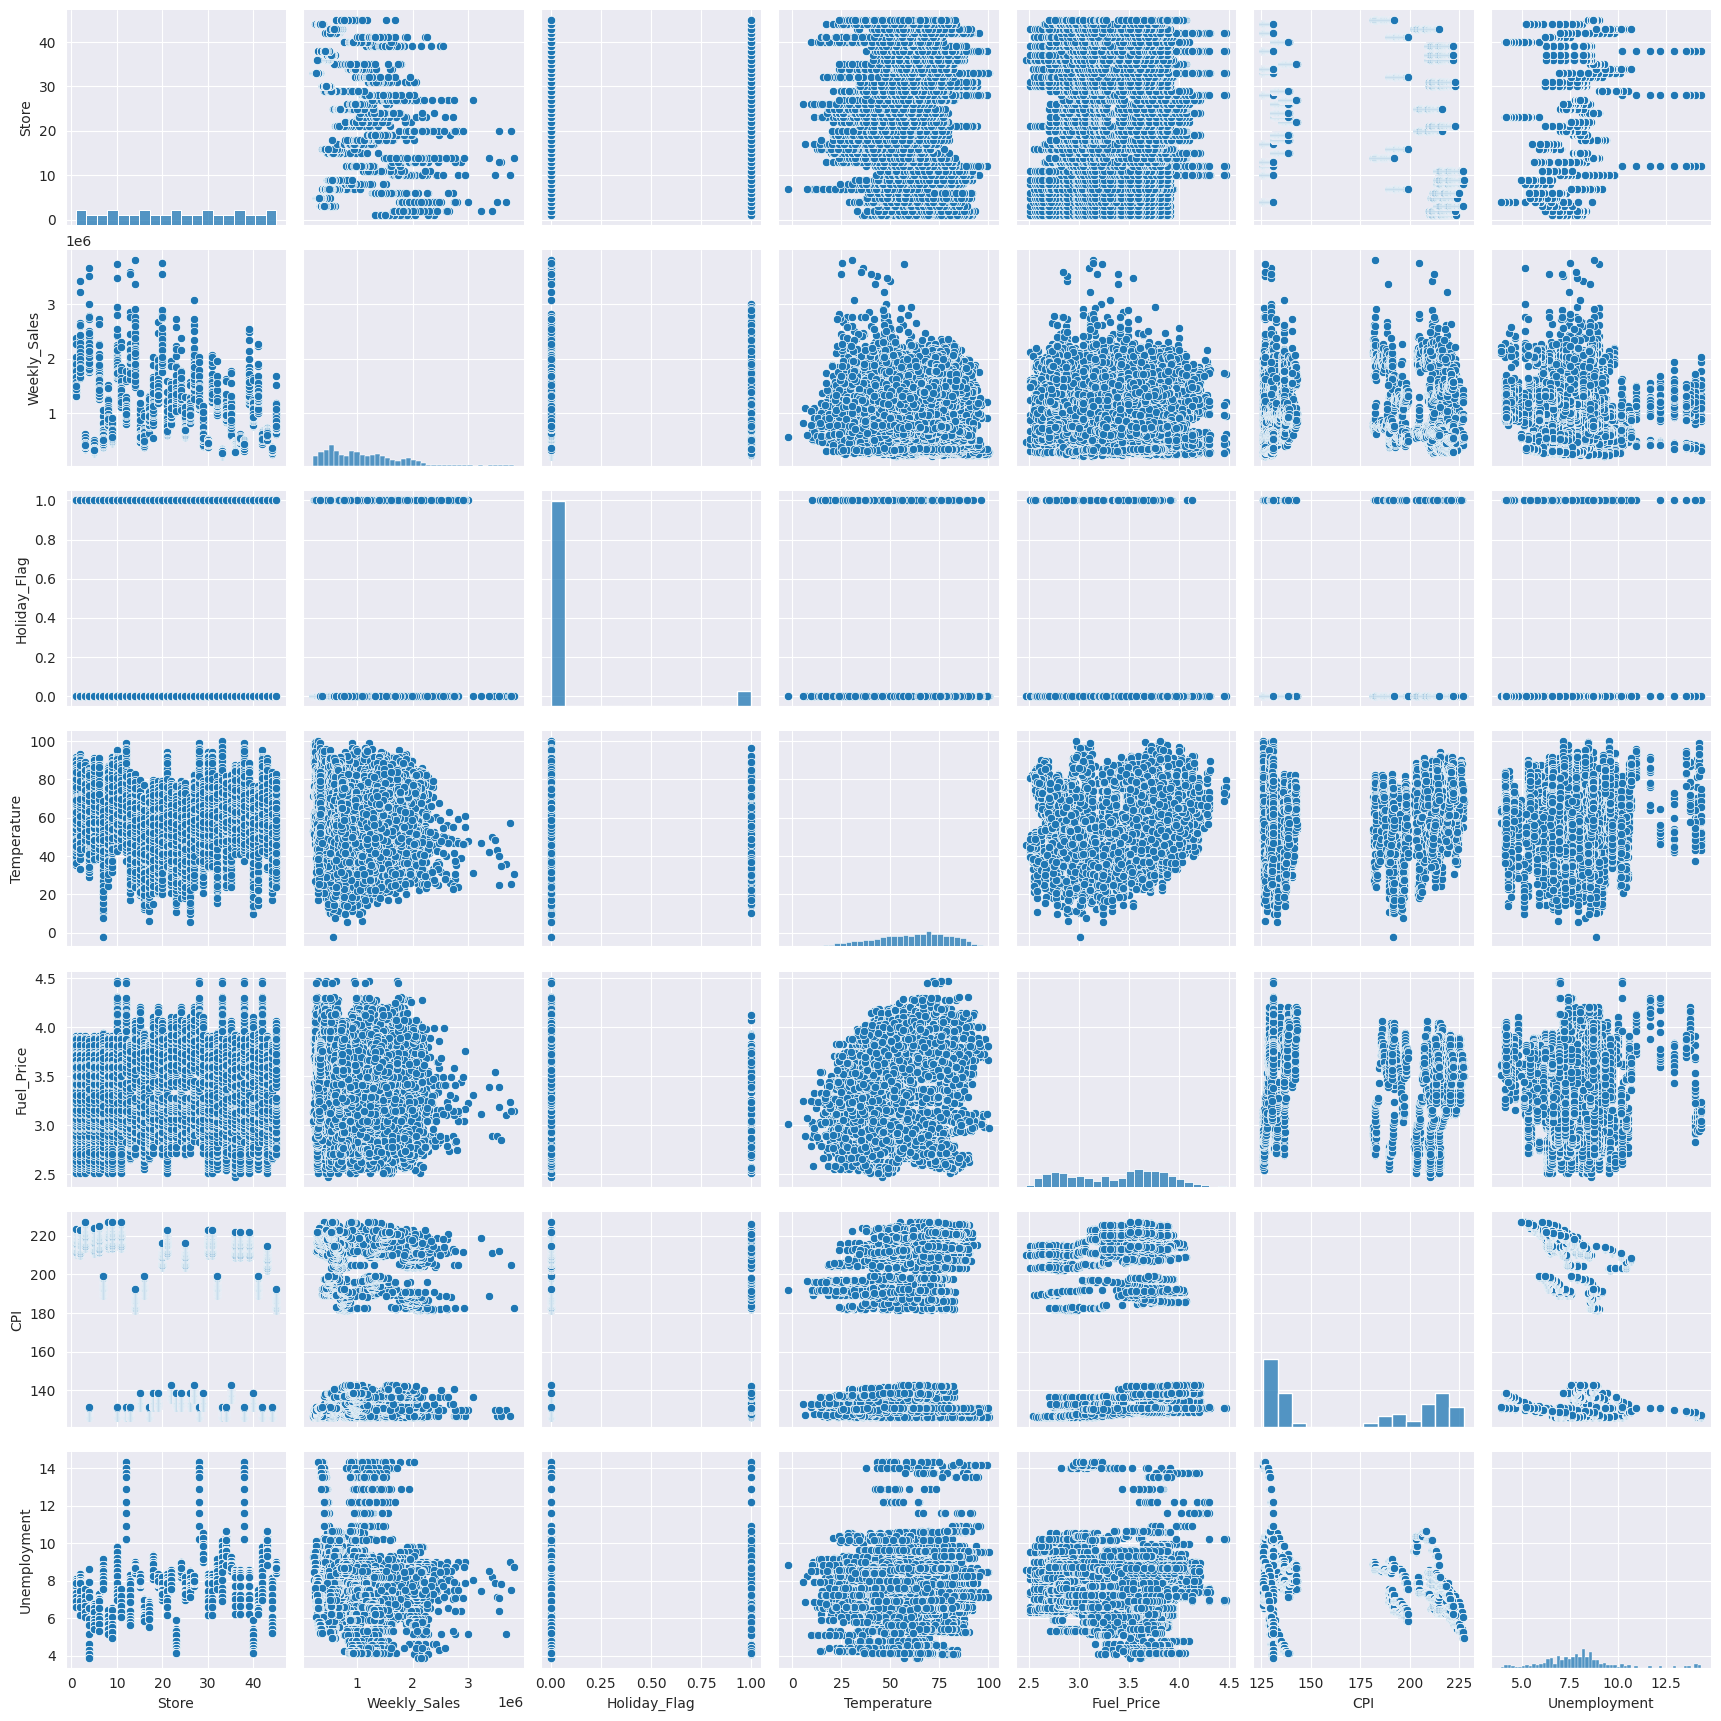

In [124]:
sns.pairplot(dataset)

## Preprocesamiento

### Reemplazar las fechas por un valor numerico (dias desde 1970-01-01)

In [125]:
norm21_dataset = dataset.copy()
norm21_dataset['Date'] = pd.to_datetime(norm21_dataset['Date'], format="%d-%m-%Y")
norm21_dataset['Date'] = (norm21_dataset['Date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1D')
norm21_dataset['Date'] = norm21_dataset['Date'].map(lambda x: int(x))
norm21_dataset.dtypes

Store             int64
Date              int64
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

### Normalizar las columnas numericas

In [126]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
columns = ['Date', 'Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
dataset_scaled = dataset.copy()
dataset_scaled[columns] = scaler.fit_transform(norm21_dataset[columns])
dataset_scaled = pd.DataFrame(dataset_scaled, columns=norm21_dataset.columns)
dataset_scaled.describe()

Store          Date  Weekly_Sales  Holiday_Flag   Temperature  \
count  6435.000000  6.435000e+03  6.435000e+03   6435.000000  6.435000e+03   
mean     23.000000 -5.520923e-18  1.766695e-17      0.069930  1.280854e-16   
std      12.988182  1.000078e+00  1.000078e+00      0.255049  1.000078e+00   
min       1.000000 -1.719981e+00 -1.483156e+00      0.000000 -3.400861e+00   
25%      12.000000 -8.721028e-01 -8.747029e-01      0.000000 -7.159044e-01   
50%      23.000000  0.000000e+00 -1.527828e-01      0.000000  1.087764e-01   
75%      34.000000  8.721028e-01  6.613126e-01      0.000000  7.740514e-01   
max      45.000000  1.719981e+00  4.911589e+00      1.000000  2.140386e+00   

         Fuel_Price           CPI  Unemployment  
count  6.435000e+03  6.435000e+03  6.435000e+03  
mean  -1.077684e-15 -7.596789e-16 -4.593408e-16  
std    1.000078e+00  1.000078e+00  1.000078e+00  
min   -1.931672e+00 -1.156548e+00 -2.196548e+00  
25%   -9.272803e-01 -1.012445e+00 -5.907810e-01  
50%    1.882269e-01  2.804854e-01 -6.672093e-02  
75%    8.200572e-01  1.046025e+00  3.320552e-01  
max    2.417063e+00  1.414212e+00  3.366059e+00

<Axes: >

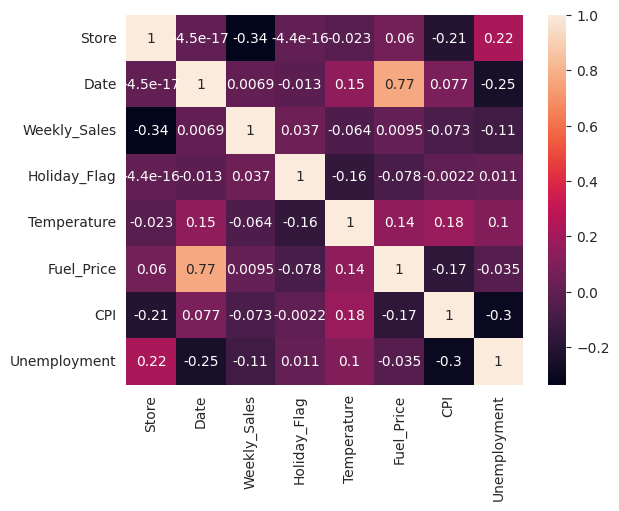

In [127]:
sns.heatmap(dataset_scaled.corr(), annot=True)

### One-hot de columnas categoricas

In [128]:
dataset_onehot = pd.get_dummies(dataset_scaled, columns=['Store', 'Holiday_Flag'], dtype=int)
dataset_onehot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 53 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            6435 non-null   float64
 1   Weekly_Sales    6435 non-null   float64
 2   Temperature     6435 non-null   float64
 3   Fuel_Price      6435 non-null   float64
 4   CPI             6435 non-null   float64
 5   Unemployment    6435 non-null   float64
 6   Store_1         6435 non-null   int64  
 7   Store_2         6435 non-null   int64  
 8   Store_3         6435 non-null   int64  
 9   Store_4         6435 non-null   int64  
 10  Store_5         6435 non-null   int64  
 11  Store_6         6435 non-null   int64  
 12  Store_7         6435 non-null   int64  
 13  Store_8         6435 non-null   int64  
 14  Store_9         6435 non-null   int64  
 15  Store_10        6435 non-null   int64  
 16  Store_11        6435 non-null   int64  
 17  Store_12        6435 non-null   i

### Separar las columnas de features y target

In [129]:
X = dataset_onehot.drop(columns=['Weekly_Sales'])
y = dataset_onehot['Weekly_Sales']

## Funciones de ploteo extra

In [130]:
def plot_prediction_output(y, y_h):
    plt.figure()
    
    inv_y = scaler.inverse_transform(X.assign(Weekly_Sales=y)[columns])[columns.index("Weekly_Sales")]
    inv_yh = scaler.inverse_transform(X.assign(Weekly_Sales=y_h)[columns])[columns.index("Weekly_Sales")]
    
    # point size = 5, transparency = 0.5
    plt.plot(inv_y, inv_yh, 'o', markersize=5, alpha=0.5)
    # Add line
    x = np.linspace(inv_y.min(), inv_y.max(), 100)
    plt.plot(x, x, 'r')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title('True vs Predicted (Weekly Sales)')
    # Log x and y
    plt.xscale('log')
    plt.yscale('log')
    plt.tight_layout()
    plt.show()
    
    
    plt.figure()
    # point size = 5, transparency = 0.5
    plt.plot(y, y_h, 'o', markersize=2, alpha=0.5)
    # Add line
    x = np.linspace(y.min(), y.max(), 100)
    plt.plot(x, x, 'r')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title('True vs Predicted (Weekly Sales std-norm scaled)')
    # Log x and y
    plt.tight_layout()
    plt.show()
    
    # Compute r2 and nmse
    from sklearn.metrics import mean_squared_error, r2_score
    print("R2", r2_score(y, y_h))
    print("NMSE", -mean_squared_error(y, y_h))


## Entrenar un modelo base de regresion lineal

La idea aca es hacer un CV de 10 folds y ver N-MSE y R2

In [131]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True, random_state=111)
model = LinearRegression()
myx = X
r2 = cross_val_score(model, myx, y, cv=kf, scoring='r2')
nmse = cross_val_score(model, myx, y, cv=kf, scoring='neg_mean_squared_error')
print("R2", r2.mean())
print("NMSE", nmse.mean())

R2 0.919171589410178
NMSE -0.08112775269867314


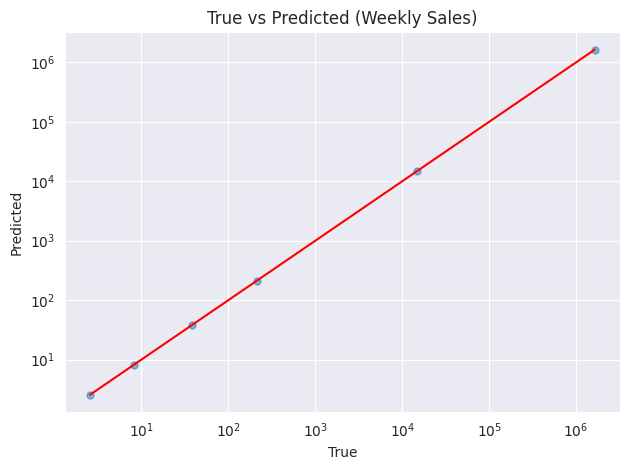

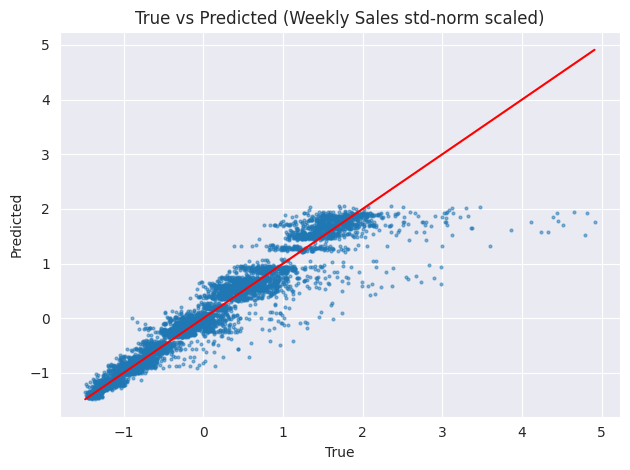

R2 0.9201960983593559
NMSE -0.0798039016406441


In [132]:
model.fit(myx, y)
plot_prediction_output(y, model.predict(myx))

## Entrenar un modelo de regresion Lasso

In [133]:

from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=True, random_state=111)
model = Lasso(alpha=0.1)
myx = X
r2 = cross_val_score(model, myx, y, cv=kf, scoring='r2')
nmse = cross_val_score(model, myx, y, cv=kf, scoring='neg_mean_squared_error')
print("R2", r2.mean())
print("NMSE", nmse.mean())


R2 0.000440088189693999
NMSE -0.9990195107548894


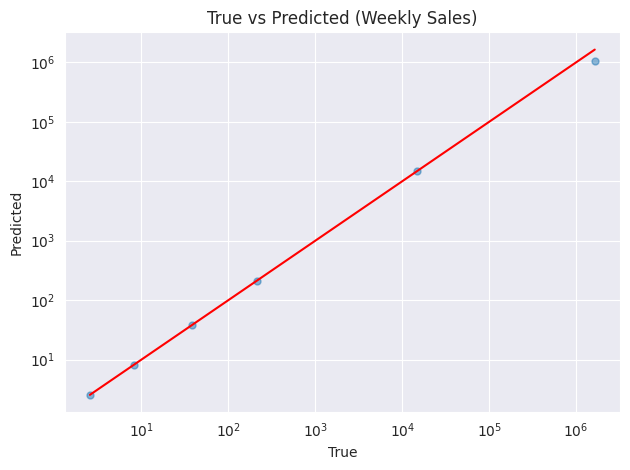

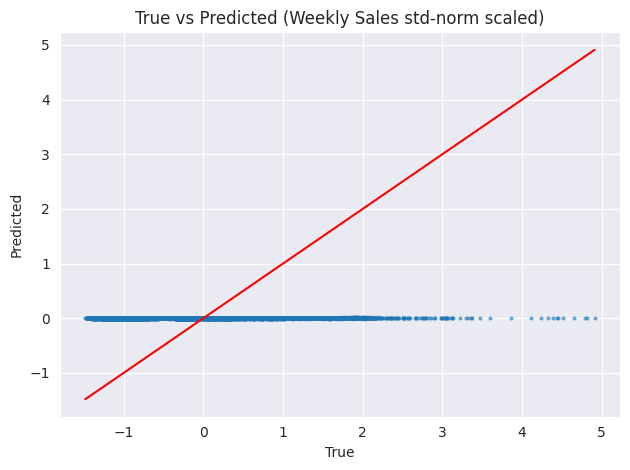

R2 0.0012733620150537917
NMSE -0.9987266379849462


In [134]:

model.fit(myx, y)
plot_prediction_output(y, model.predict(myx))